In [1]:
from functions import cholesky_tsqr, direct_tsqr, indirect_tsqr


In [2]:
import time
from dask.distributed import wait
import numpy as np


In [ ]:
from dask.distributed import Client, LocalCluster

# Example: 4 workers, 1 thread each
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

print("Dashboard:", client.dashboard_link)


Dashboard: http://127.0.0.1:8787/status


2025-09-14 23:37:54,549 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/riccorte/miniconda3/envs/dask-env/lib/python3.11/site-packages/tornado/websocket.py", line 965, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/riccorte/miniconda3/envs/dask-env/lib/python3.11/site-packages/tornado/web.py", line 3375, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/riccorte/miniconda3/envs/dask-env/lib/python3.11/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired. Configure the app with a larger value for --session-token-expiration if necessary")
bok

In [4]:
# check if everything went smoothly
print(client)
print(cluster)


<Client: 'tcp://127.0.0.1:41971' processes=4 threads=4, memory=5.79 GiB>
LocalCluster(642c3124, 'tcp://127.0.0.1:41971', workers=4, threads=4, memory=5.79 GiB)


In [5]:
import dask.array as da
import dask
import numpy as np
import time
from scipy.linalg import solve_triangular 
from sklearn.datasets import fetch_california_housing

# Download California Housing dataset
data = fetch_california_housing(as_frame=True)

# Convert features into Dask Array (it's a matrix).
n_partition = 3        # number of partition in memory. We have 4 VMS (1 master + 3 workers), so let's start with just 3 partitions
length_partition = data.data.shape[0] // n_partition
X_da = da.from_array(data.data.values, chunks=(length_partition, data.data.shape[1]))

print("Number of Dask partitions:",  X_da.npartitions) 
print("Length of each partition:", length_partition, "rows")
print("Length of the whole dataset:", data.data.shape[0], "rows")


Number of Dask partitions: 3
Length of each partition: 6880 rows
Length of the whole dataset: 20640 rows


In [6]:
#X_cached = X_da.rechunk((1_000_000, -1)).persist()

print(X_da)
A0 = X_da.rechunk((1_000_000, -1))


dask.array<array, shape=(20640, 8), dtype=float64, chunksize=(6880, 8), chunktype=numpy.ndarray>


In [7]:
import time
import numpy as np
from dask.distributed import wait
from time import sleep

def ensure_scaled(target, timeout=60):
    """Request scaling and wait until at least `target` workers are available.
       Returns the actual number of workers available (may be > target)."""
    cluster.scale(target)
    t0 = time.time()
    while time.time() - t0 < timeout:
        info = client.scheduler_info()
        nworkers = len(info.get("workers", {}))
        if nworkers >= target:
            return nworkers
        sleep(0.5)
    # timeout expired — return current state
    return len(client.scheduler_info().get("workers", {}))

def print_workers_info():
    info = client.scheduler_info().get("workers", {})
    for addr, w in info.items():
        print(addr, "nthreads:", w.get("nthreads"), "processing:", len(w.get("processing", {})),
              "memory:", w.get("memory_limit"))

def run_once_indirect(A):
    t0 = time.time()
    Q, R = indirect_tsqr(A)
    Q = Q.persist()
    try:
        wait(Q, timeout=120)    # avoid hanging forever
    except Exception as e:
        print("wait(Q) raised:", repr(e))
        # show scheduler state for debugging
        print_workers_info()
        raise
    t1 = time.time()
    client.cancel(Q)
    return t1 - t0

def time_vs_workers(workers_list, reps=2):
    results = {}
    for w in workers_list:
        actual = ensure_scaled(w, timeout=120)
        print(f"\nRequested {w}, actual available {actual}")
        print_workers_info()

        # adapt chunking to available workers so tasks can be distributed
        # here we assume A0 has its first axis as the partitioning axis
        try:
            n_rows = int(A0.shape[0])
            rows_per_chunk = (n_rows + actual - 1) // actual  # ceil division
            A = A0.rechunk((rows_per_chunk, -1)).persist()
            wait(A, timeout=120)
        except Exception as e:
            print("Error persisting A after rechunk:", repr(e))
            print_workers_info()
            # Try a simpler test to see if workers can do anything:
            test = client.submit(lambda x: x+1, 1)
            print("simple submit result:", test.result(timeout=10))
            raise

        # Warmup + measures
        _ = run_once_indirect(A)
        times = [run_once_indirect(A) for _ in range(reps)]
        results[w] = (float(np.mean(times)), float(np.std(times)))
        print(f"w={w}: mean={results[w][0]:.3f}s  std={results[w][1]:.3f}s")

        # cleanup
        client.cancel(A)
        del A
        # optionally scale down between runs:
        # cluster.scale(0)
        # sleep(2)

    return results


In [8]:
# ESEMPIO: misura con 1, 2, 4, 8 worker (se la macchina lo consente)
res = time_vs_workers([1,2,3, 4], reps=2)
print("\nRisultati:", res)



Requested 1, actual available 4
tcp://127.0.0.1:42111 nthreads: 1 processing: 0 memory: 1554740224
tcp://127.0.0.1:46661 nthreads: 1 processing: 0 memory: 1554740224
w=1: mean=0.170s  std=0.036s

Requested 2, actual available 2
tcp://127.0.0.1:42111 nthreads: 1 processing: 0 memory: 1554740224
tcp://127.0.0.1:45679 nthreads: 1 processing: 0 memory: 1554740224
w=2: mean=0.159s  std=0.009s

Requested 3, actual available 3
tcp://127.0.0.1:42111 nthreads: 1 processing: 0 memory: 1554740224
tcp://127.0.0.1:44681 nthreads: 1 processing: 0 memory: 1554740224
tcp://127.0.0.1:45679 nthreads: 1 processing: 0 memory: 1554740224
w=3: mean=0.178s  std=0.004s

Requested 4, actual available 4
tcp://127.0.0.1:39341 nthreads: 1 processing: 0 memory: 1554740224
tcp://127.0.0.1:42111 nthreads: 1 processing: 0 memory: 1554740224
tcp://127.0.0.1:44681 nthreads: 1 processing: 0 memory: 1554740224
tcp://127.0.0.1:45679 nthreads: 1 processing: 0 memory: 1554740224
w=4: mean=0.153s  std=0.020s

Risultati: {1:

### New Clean Approach for SSH clusters:

In [10]:
import time
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, SSHCluster, wait
import os


# ---------- Generic runner ----------

def benchmark_once(A, tsqr_func, client, timeout=300):
    """Run one TSQR variant once on A.
    Works even if functions return (Q, R) with mixed types or just R."""
    import time
    t0 = time.time()
    result = tsqr_func(A)

  
    Q, R = result
    # Persist only if Dask objects
    if hasattr(Q, "persist"):
        Q = Q.persist()
        wait(Q, timeout=timeout)
        client.cancel(Q)
    if hasattr(R, "persist"):   # in case R is also a Dask object
        R = R.persist()
        wait(R, timeout=timeout)
        client.cancel(R)

    t1 = time.time()
    return t1 - t0


In [11]:

def benchmark_funcs(A, reps=3):
    results = {}
    funcs = {
        "indirect": indirect_tsqr,
        "direct": direct_tsqr,
        "cholesky": cholesky_tsqr,
    }
    for name, func in funcs.items():
        times = [benchmark_once(A, func) for _ in range(reps)]
        results[name] = (np.mean(times), np.std(times))
    return results

# --- Step 2: loop over worker counts ---
def run_scaling_experiment(hosts, worker_counts, reps=3):
    scaling_results = { "indirect": [], "direct": [], "cholesky": [] }

    for w in worker_counts:
        print(f"\n=== Running with {w} workers ===")

        # recreate cluster with given nprocs (workers per host)
        cluster = SSHCluster(
            hosts,
            connect_options={"known_hosts": None},
            remote_python="/home/ubuntu/miniconda3/bin/python",
            worker_options={"nprocs": w, "nthreads": 1},
            scheduler_options={"port": 8786, "dashboard_address": ":8797"},
        )
        global client
        client = Client(cluster)

        # Rechunk input across workers
        n_rows = int(A0.shape[0])
        rows_per_chunk = (n_rows + w - 1) // w
        A = A0.rechunk((rows_per_chunk, -1)).persist()
        wait(A)

        # Run benchmarks
        results = benchmark_funcs(A, reps=reps)
        for name, (mean, std) in results.items():
            scaling_results[name].append((w, mean, std))

        client.close()
        cluster.close()

    return scaling_results

# --- Step 3: plot ---
def plot_results(scaling_results):
    plt.figure(figsize=(8,5))
    for name, data in scaling_results.items():
        ws, means, stds = zip(*data)
        plt.errorbar(ws, means, yerr=stds, marker="o", label=name)
    plt.xlabel("Number of workers")
    plt.ylabel("Time (s)")
    plt.title("TSQR runtimes vs. workers")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from dask.distributed import Client, LocalCluster

# Example: 4 workers, 1 thread each
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

print("Dashboard:", client.dashboard_link)


In [12]:
hosts = ["10.67.22.154", "10.67.22.216", "10.67.22.116", "10.67.22.113"]
worker_counts = [1, 2, 3, 4]   # adjust depending on your setup
scaling_results = run_scaling_experiment(hosts, worker_counts, reps=5)
plot_results(scaling_results)



=== Running with 1 workers ===


2025-09-14 23:32:55,950 - distributed.deploy.spec - WARNING - Cluster closed without starting up


RuntimeError: Cluster failed to start: Public key mismatch

In [ ]:
client.close()
cluster.close()


In [23]:
from dask.distributed import Client, LocalCluster, wait, get_client
import numpy as np
import matplotlib.pyplot as plt
import time

def benchmark_once(A, tsqr_func, timeout=300):
    """Run one TSQR variant once on A.
    Works even if functions return (Q, R) with mixed types or just R."""
    import time
    t0 = time.time()
    result = tsqr_func(A)

  
    Q, R = result
    client = get_client()
    # Persist only if Dask objects
    if hasattr(Q, "persist"):
        Q = Q.persist()
        wait(Q, timeout=timeout)
        client.cancel(Q)
    if hasattr(R, "persist"):   # in case R is also a Dask object
        R = R.persist()
        wait(R, timeout=timeout)
        client.cancel(R)

    t1 = time.time()
    return t1 - t0

def benchmark_funcs(A, reps=3):
    funcs = {"indirect": indirect_tsqr, "direct": direct_tsqr, "cholesky": cholesky_tsqr}
    out = {}
    for name, f in funcs.items():
        _ = benchmark_once(A, f)                         # warmup
        times = [benchmark_once(A, f) for _ in range(reps)]
        out[name] = (float(np.mean(times)), float(np.std(times)))
    return out

def run_scaling_experiment_local(A0, worker_counts, reps=3):
    results = {"indirect": [], "direct": [], "cholesky": []}
    for w in worker_counts:
        # fresh LocalCluster each time (simple & reliable)
        cluster = LocalCluster(n_workers=w, threads_per_worker=1, dashboard_address=":8787")
        global client
        client = Client(cluster)
        # rechunk roughly by workers (simple version)
        n_rows = int(A0.shape[0])
        rows_per_chunk = max(1, (n_rows + (w*3) - 1) // (w*3))  # ~3 chunks per worker
        A = A0.rechunk((rows_per_chunk, -1)).persist(); wait(A)

        res = benchmark_funcs(A, reps=reps)
        for name, (m,s) in res.items():
            results[name].append((w, m, s))

        client.close(); cluster.close()
    return results

def plot_results(scaling_results):
    plt.figure(figsize=(8,5))
    for name, data in scaling_results.items():
        ws, means, stds = zip(*data)
        plt.errorbar(ws, means, yerr=stds, marker="o", label=name)
    plt.xlabel("Number of workers"); plt.ylabel("Time (s)")
    plt.title("TSQR runtimes vs workers (LocalCluster)")
    plt.grid(True); plt.legend(); plt.show()


/home/riccorte/miniconda3/envs/dask-env/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41319 instead
  warnings.warn(
/home/riccorte/miniconda3/envs/dask-env/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34395 instead
  warnings.warn(
/home/riccorte/miniconda3/envs/dask-env/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34887 instead
  warnings.warn(


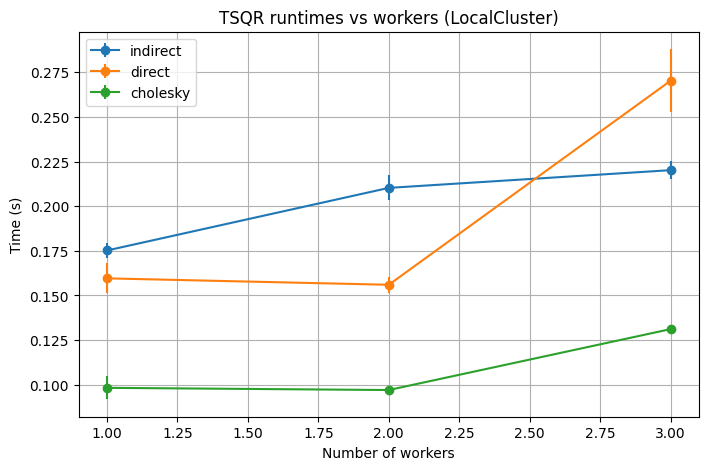

In [24]:
# A0 must be your Dask Array (features only)
worker_counts = [1, 2, 3]
scaling_results = run_scaling_experiment_local(A0, worker_counts, reps=3)
plot_results(scaling_results)
